In [ ]:
!pip install recommenders cornac==2.3.0 optuna==4.2.1

In [ ]:
!add-apt-repository ppa:ubuntu-toolchain-r/test
!apt-get update
!apt-get install --only-upgrade libstdc++6

In [1]:
import pandas as pd
import sys
import cornac
import itertools
import optuna

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_random_split, python_chrono_split
from recommenders.evaluation.python_evaluation import (
    rmse,
    mae,
    rsquared,
    exp_var,
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
    get_top_k_items,
)

from recommenders.utils.notebook_utils import store_metadata
from recommenders.models.cornac.cornac_utils import predict_ranking
from cornac.eval_methods import NextItemEvaluation

from collections import OrderedDict, defaultdict
import numpy as np
from tqdm.notebook import tqdm

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Optuna Version: {optuna.__version__}")

System version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Cornac version: 2.3.0
Optuna Version: 4.2.1


In [2]:
DATA_PATH = '/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/ml-1m/data_split/'

In [3]:
train_data = pd.read_csv(f'{DATA_PATH}/data_train.tsv', sep='\t')
valid_data = pd.read_csv(f'{DATA_PATH}/data_valid.tsv', sep='\t')

In [4]:
# top k items to recommend
TOP_K = 20
NUM_EPOCHS = 20
SEED=100

In [5]:
def ranking_eval(
    model,
    train_set,
    test_set,
    exclude_unknowns=True,
    mode="last",
    verbose=False,
):

    rankings = []
    scores = []
    user_sessions = defaultdict(list)
    session_ids = []
    for [sid], [mapped_ids], [session_items] in tqdm(
        test_set.si_iter(batch_size=1, shuffle=False),
        total=len(test_set.sessions)):

        if len(session_items) < 2:  # exclude all session with size smaller than 2
            continue
        user_idx = test_set.uir_tuple[0][mapped_ids[0]]
        session_ids.append(sid)

        start_pos = 1 if mode == "next" else len(session_items) - 1
        for test_pos in range(start_pos, len(session_items), 1):
            test_pos_items = session_items[test_pos]

            # binary mask for ground-truth positive items
            u_gt_pos_mask = np.zeros(test_set.num_items, dtype="int")
            u_gt_pos_mask[test_pos_items] = 1

            # binary mask for ground-truth negative items, removing all positive items
            u_gt_neg_mask = np.ones(test_set.num_items, dtype="int")
            u_gt_neg_mask[test_pos_items] = 0

            # filter items being considered for evaluation
            if exclude_unknowns:
                u_gt_pos_mask = u_gt_pos_mask[: train_set.num_items]
                u_gt_neg_mask = u_gt_neg_mask[: train_set.num_items]

            u_gt_pos_items = np.nonzero(u_gt_pos_mask)[0]
            u_gt_neg_items = np.nonzero(u_gt_neg_mask)[0]
            item_indices = np.nonzero(u_gt_pos_mask + u_gt_neg_mask)[0]


            item_rank, item_scores = model.rank(
                user_idx,
                item_indices,
                history_items=session_items[:test_pos],
                history_mapped_ids=mapped_ids[:test_pos],
                sessions=test_set.sessions,
                session_indices=test_set.session_indices,
                extra_data=test_set.extra_data,
            )
            item_scores = item_scores[item_rank]
            item_rank = [key for value in item_rank for key, val in train_set.iid_map.items() if val == value]

            rankings.append(item_rank)
            scores.append(item_scores)

    return rankings, scores

In [6]:
class Objective(object):
    def __init__(self, train_data, valid_data):
        next_item_eval = NextItemEvaluation.from_splits(
            train_data=list(train_data[['user_id', 'movie_id', 'timestamp']].itertuples(index=False)),
            test_data=list(valid_data[['user_id', 'movie_id', 'timestamp']].itertuples(index=False)),
            exclude_unknowns=True,
            verbose=False,
            fmt="SIT",
        )
        self.train_data = train_data
        self.valid_data = valid_data
        self.train_set = next_item_eval.train_set
        self.valid_set = next_item_eval.test_set

    def __call__(self, trial):

        layers = trial.suggest_int("layers", 100, 500, step=50)
        learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
        dropout_p_embed = trial.suggest_float("dropout_p_embed", 0, 0.5)
        dropout_p_hidden = trial.suggest_float("dropout_p_hidden", 0, 0.5)
        loss = trial.suggest_categorical("loss", ["cross-entropy", "bpr-max"])
        gru = cornac.models.GRU4Rec(
            layers=[layers],
            loss=loss,
            learning_rate=learning_rate,
            dropout_p_embed=dropout_p_embed,
            dropout_p_hidden=dropout_p_hidden,
            batch_size=128,
            n_epochs=NUM_EPOCHS,
            device="cuda",
            verbose=True,
            seed=SEED,
        )
        gru.fit(self.train_set)
        gru.transform(self.valid_set)

        gru_ranking, gru_scores = ranking_eval(
          gru,
          self.train_set,
          self.valid_set,
          exclude_unknowns=True,
          mode="last",
          verbose=False,
        )
        users = []
        item = list(gru.train_set.iid_map.keys())
        for uid, user_idx in gru.train_set.sid_map.items():
            user = [uid] * len(item)
            users.extend(user)

        flattened_ranking = list(itertools.chain(*gru_ranking))
        flattened_score= list(itertools.chain(*gru_scores))

        df_gru_predictions = pd.DataFrame({'user_id':users, 'movie_id':flattened_ranking, 'prediction': flattened_score})

        ndcg_score = ndcg_at_k(self.valid_data, df_gru_predictions, col_user="user_id", col_item="movie_id", col_rating='rating', k=10)

        return ndcg_score

In [ ]:
objective = Objective(train_data, valid_data)
study_name = "movielens-gru"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name)
study.optimize(objective, n_trials=10, n_jobs=2)

[I 2025-05-05 08:06:09,737] A new study created in RDB with name: movielens-gru


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-05-05 13:06:34,099] Trial 1 finished with value: 0.2110506869417047 and parameters: {'layers': 450, 'learning_rate': 0.013127940063968663, 'dropout_p_embed': 0.1787668321670527, 'dropout_p_hidden': 0.2731337500822055, 'loss': 'cross-entropy'}. Best is trial 1 with value: 0.2110506869417047.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-05 13:34:11,426] Trial 0 finished with value: 0.17814298707372844 and parameters: {'layers': 350, 'learning_rate': 0.013242857895418741, 'dropout_p_embed': 0.10844685850298519, 'dropout_p_hidden': 0.26670024101194395, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.2110506869417047.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-05-05 16:59:03,332] Trial 3 finished with value: 0.0500941109819071 and parameters: {'layers': 100, 'learning_rate': 0.001265830249511231, 'dropout_p_embed': 0.3187063532429389, 'dropout_p_hidden': 0.36357443071621537, 'loss': 'cross-entropy'}. Best is trial 1 with value: 0.2110506869417047.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-05 18:58:26,637] Trial 2 finished with value: 0.2540445065311978 and parameters: {'layers': 500, 'learning_rate': 0.0054108878419468175, 'dropout_p_embed': 0.26000486839717546, 'dropout_p_hidden': 0.33075452442305814, 'loss': 'bpr-max'}. Best is trial 2 with value: 0.2540445065311978.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-05-05 21:41:36,461] Trial 4 finished with value: 0.2123099341913254 and parameters: {'layers': 500, 'learning_rate': 0.012393528822139288, 'dropout_p_embed': 0.39283290327945125, 'dropout_p_hidden': 0.29016719110238254, 'loss': 'cross-entropy'}. Best is trial 2 with value: 0.2540445065311978.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-05-06 00:21:49,720] Trial 5 finished with value: 0.11822686462923249 and parameters: {'layers': 500, 'learning_rate': 0.026480098611846647, 'dropout_p_embed': 0.09651635065405906, 'dropout_p_hidden': 0.4271798485391881, 'loss': 'bpr-max'}. Best is trial 2 with value: 0.2540445065311978.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-05-06 03:03:08,049] Trial 6 finished with value: 0.1253946645756724 and parameters: {'layers': 300, 'learning_rate': 0.0020817693238629077, 'dropout_p_embed': 0.1096878227480903, 'dropout_p_hidden': 0.11676318989949958, 'loss': 'cross-entropy'}. Best is trial 2 with value: 0.2540445065311978.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-05-06 05:44:00,809] Trial 7 finished with value: 0.08151950829327814 and parameters: {'layers': 450, 'learning_rate': 0.0010406376298420649, 'dropout_p_embed': 0.15239111411072143, 'dropout_p_hidden': 0.07424705246500735, 'loss': 'cross-entropy'}. Best is trial 2 with value: 0.2540445065311978.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

## Continue Optimization

In [7]:
!cp "/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/sqlite-optimization/movielens-gru.db" .

In [9]:
study_name = "movielens-gru"
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)

[I 2025-05-06 11:56:55,375] Using an existing study with name 'movielens-gru' instead of creating a new one.


In [11]:
df = study.trials_dataframe()

In [12]:
df

,number,value,datetime_start,datetime_complete,duration,params_dropout_p_embed,params_dropout_p_hidden,params_layers,params_learning_rate,params_loss,state
0,0,0.178143,2025-05-05 08:06:09.750209,2025-05-05 13:34:11.410034,0 days 05:28:01.659825,0.108447,0.266700,350,0.013243,bpr-max,COMPLETE
1,1,0.211051,2025-05-05 08:06:09.752063,2025-05-05 13:06:33.871975,0 days 05:00:24.119912,0.178767,0.273134,450,0.013128,cross-entropy,COMPLETE
2,2,0.254045,2025-05-05 13:06:34.268504,2025-05-05 18:58:26.620316,0 days 05:51:52.351812,0.260005,0.330755,500,0.005411,bpr-max,COMPLETE
3,3,0.050094,2025-05-05 13:34:11.435107,2025-05-05 16:59:03.316942,0 days 03:24:51.881835,0.318706,0.363574,100,0.001266,cross-entropy,COMPLETE
4,4,0.212310,2025-05-05 16:59:03.340679,2025-05-05 21:41:36.445101,0 days 04:42:33.104422,0.392833,0.290167,500,0.012394,cross-entropy,COMPLETE
5,5,0.118227,2025-05-05 18:58:26.645438,2025-05-06 00:21:49.703933,0 days 05:23:23.058495,0.096516,0.427180,500,0.026480,bpr-max,COMPLETE
6,6,0.125395,2025-05-05 21:41:36.469419,2025-05-06 03:03:08.032899,0 days 05:21:31.563480,0.109688,0.116763,300,0.002082,cross-entropy,COMPLETE
7,7,0.081520,2025-05-06 00:21:49.729696,2025-05-06 05:44:00.794270,0 days 05:22:11.064574,0.152391,0.074247,450,0.001041,cross-entropy,COMPLETE
8,8,NaN,2025-05-06 03:03:08.057366,NaT,NaT,0.084415,0.284035,150,0.006394,bpr-max,RUNNING
9,9,NaN,2025-05-06 05:44:00.817067,NaT,NaT,0.466020,0.363969,450,0.003123,cross-entropy,RUNNING


In [13]:
objective = Objective(train_data, valid_data)
study.optimize(objective, n_trials=2, n_jobs=2)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-05-06 17:06:18,089] Trial 10 finished with value: 0.2711011941710775 and parameters: {'layers': 450, 'learning_rate': 0.0074183417560466786, 'dropout_p_embed': 0.1891316122768898, 'dropout_p_hidden': 0.4621455893237307, 'loss': 'bpr-max'}. Best is trial 10 with value: 0.2711011941710775.
[I 2025-05-06 17:24:07,122] Trial 11 finished with value: 0.1010311199712997 and parameters: {'layers': 250, 'learning_rate': 0.061997809978554495, 'dropout_p_embed': 0.014017927063258828, 'dropout_p_hidden': 0.17730605326618631, 'loss': 'bpr-max'}. Best is trial 10 with value: 0.2711011941710775.


In [14]:
print(study.best_trial)

FrozenTrial(number=10, state=1, values=[0.2711011941710775], datetime_start=datetime.datetime(2025, 5, 6, 11, 58, 34, 219092), datetime_complete=datetime.datetime(2025, 5, 6, 17, 6, 17, 783406), params={'layers': 450, 'learning_rate': 0.0074183417560466786, 'dropout_p_embed': 0.1891316122768898, 'dropout_p_hidden': 0.4621455893237307, 'loss': 'bpr-max'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'layers': IntDistribution(high=500, log=False, low=100, step=50), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'dropout_p_embed': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dropout_p_hidden': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'loss': CategoricalDistribution(choices=('cross-entropy', 'bpr-max'))}, trial_id=11, value=None)


In [15]:
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print("Trials: ", study.trials)

Best params:  {'layers': 450, 'learning_rate': 0.0074183417560466786, 'dropout_p_embed': 0.1891316122768898, 'dropout_p_hidden': 0.4621455893237307, 'loss': 'bpr-max'}
Best value:  0.2711011941710775
Best Trial:  FrozenTrial(number=10, state=1, values=[0.2711011941710775], datetime_start=datetime.datetime(2025, 5, 6, 11, 58, 34, 219092), datetime_complete=datetime.datetime(2025, 5, 6, 17, 6, 17, 783406), params={'layers': 450, 'learning_rate': 0.0074183417560466786, 'dropout_p_embed': 0.1891316122768898, 'dropout_p_hidden': 0.4621455893237307, 'loss': 'bpr-max'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'layers': IntDistribution(high=500, log=False, low=100, step=50), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'dropout_p_embed': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dropout_p_hidden': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'loss': CategoricalDistribution(choices=('cross-entropy'

In [18]:
import pickle

In [19]:
with open("/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/ml-1m/model/GRU4Rec/optuna_sampler_2025-05-05.pkl", "wb") as fout:
  pickle.dump(study.sampler, fout)

In [20]:
optuna.visualization.plot_optimization_history(study)

In [21]:
optuna.visualization.plot_parallel_coordinate(study)

In [22]:
optuna.visualization.plot_contour(study)

In [23]:
optuna.visualization.plot_slice(study)

In [24]:
optuna.visualization.plot_slice(study, params=["layers"])

In [25]:
optuna.visualization.plot_slice(study, params=["loss"])

In [26]:
optuna.visualization.plot_slice(study, params=["learning_rate"])

In [27]:
optuna.visualization.plot_slice(study, params=["dropout_p_embed"])

In [28]:
optuna.visualization.plot_slice(study, params=["dropout_p_hidden"])

In [29]:
optuna.visualization.plot_param_importances(study)

In [30]:
optuna.visualization.plot_edf(study)

In [31]:
optuna.visualization.plot_rank(study)

In [32]:
optuna.visualization.plot_timeline(study)

## Epoch Parameter

In [92]:
train_data_full = pd.read_csv(f'{DATA_PATH}/data_train_full.tsv', sep='\t')
test_data = pd.read_csv(f'{DATA_PATH}/data_test.tsv', sep='\t')

In [93]:
unique_user_id = test_data['user_id'].unique()

In [94]:
len(unique_user_id)

5755

In [102]:
sample_500_user = np.random.choice(unique_user_id, 500, replace=False)

In [103]:
sample_test_set = test_data[test_data.user_id.isin(sample_500_user)]

In [104]:
len(test_data), len(sample_test_set)

(166351, 15131)

In [107]:
next_item_eval = NextItemEvaluation.from_splits(
  train_data=list(train_data_full[['user_id', 'movie_id', 'timestamp']].itertuples(index=False)),
  test_data=list(sample_test_set[['user_id', 'movie_id', 'timestamp']].itertuples(index=False)),
  exclude_unknowns=True,
  verbose=True,
  fmt="SIT",
)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 1
Number of items = 3571
Number of sessions = 5755
---
Test data:
Number of users = 1
Number of items = 3571
Number of sessions = 500
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 1
Total items = 3571
Total sessions = 6255


In [108]:
from tqdm.notebook import tqdm
import time

In [109]:
epoch_result_gru = {}

In [110]:
##Best params:  {'layers': 450, 'learning_rate': 0.0074183417560466786, 'dropout_p_embed': 0.1891316122768898, 'dropout_p_hidden': 0.4621455893237307, 'loss': 'bpr-max'}

for epoch in tqdm(range(20,110,20)):

  gru = cornac.models.GRU4Rec(
            layers=[450],
            loss='bpr-max',
            learning_rate=0.0074,
            dropout_p_embed=0.1891,
            dropout_p_hidden=0.4621,
            batch_size=128,
            n_epochs=epoch,
            device="cuda",
            verbose=True,
            seed=SEED,
        )

  start_time = time.time()
  gru.fit(next_item_eval.train_set)
  gru.transform(next_item_eval.test_set)
  train_time = time.time() - start_time

  start_time = time.time()
  gru_ranking, gru_scores = ranking_eval(
    gru,
    next_item_eval.train_set,
    next_item_eval.test_set,
    exclude_unknowns=True,
    mode="last",
    verbose=False,
  )
  prediction_time = time.time() - start_time

  users = []
  item = list(gru.train_set.iid_map.keys())
  for uid, user_idx in gru.train_set.sid_map.items():
      if uid in sample_500_user:
        user = [uid] * len(item)
        users.extend(user)

  flattened_ranking = list(itertools.chain(*gru_ranking))
  flattened_score= list(itertools.chain(*gru_scores))

  df_gru_predictions = pd.DataFrame({'user_id':users, 'movie_id':flattened_ranking, 'prediction': flattened_score})

  ndcg_score = ndcg_at_k(test_data, df_gru_predictions, col_user="user_id", col_item="movie_id", col_rating='rating', k=10)
  epoch_result_gru[epoch] = {'ndcg':ndcg_score, 'train_time': train_time, 'prediction_time': prediction_time}
  print(f"epoch: {epoch}\t ndcg:{ndcg_score}")


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 20	 ndcg:0.021647598593770474


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 40	 ndcg:0.02124092810366146


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 60	 ndcg:0.020355034513425744


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 80	 ndcg:0.019232302334724165


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 100	 ndcg:0.018395270150325733


In [111]:
epoch_df = pd.DataFrame(epoch_result_gru).T.reset_index()

In [112]:
epoch_df = epoch_df.rename(columns={"index":"epoch"})

In [113]:
epoch_df

,epoch,ndcg,train_time,prediction_time
0,20,0.021648,509.479293,845.788152
1,40,0.021241,1025.348548,845.126188
2,60,0.020355,1526.359230,845.495187
3,80,0.019232,2031.178518,845.696845
4,100,0.018395,2535.896120,846.958302


In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

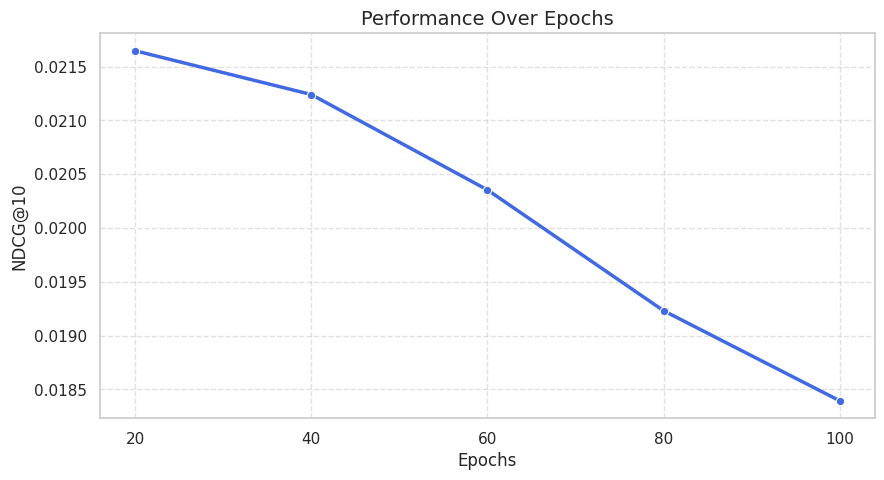

In [115]:
sns.set(style="whitegrid")

# Plot 1: Performance vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="ndcg", marker="o", linewidth=2.5, color="royalblue")
plt.title("Performance Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("NDCG@10", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

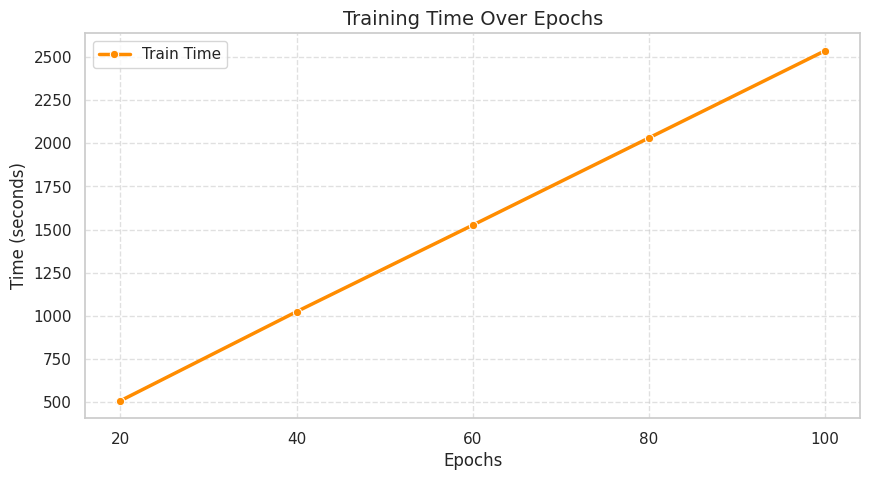

In [116]:
# Plot 2: Train Time & Prediction Time vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="train_time", marker="o", linewidth=2.5, label="Train Time", color="darkorange")
plt.title("Training Time Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()